In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', titlesize=25)

# Loading data

We will consider two datasets for binary classification task.
First dataset will be the **Banknote authentication dataset**. It concerns the task of detecting, whether the banknote is authentic or not, based on values such as skewness, curtosis, image entropy etc. The dataset is available [here](https://archive.ics.uci.edu/ml/datasets/banknote+authentication)
The second dataset is the **Titanic dataset**. The goal is to predict whether a person was likely to survive, based on values such as age, sex, ticket fare etc. The dataset is available [here](https://www.kaggle.com/competitions/titanic/overview)

In [3]:
bank_df = pd.read_csv('data/data_banknote_authentication.txt', header=None, na_values='?')
titanic_df = pd.read_csv('data/train.csv')
titanic_df = titanic_df.drop('PassengerId',axis=1)
bank_df.columns = ['variance', 'skewness', 'kurtosis', 'entropy', 'class']

In [4]:
categorical_columns = titanic_df.select_dtypes(include=['object']).columns
numerical_columns = titanic_df.select_dtypes(include=['int64', 'float64']).columns[1:]
bank_variables = bank_df.iloc[:,:-1].columns

# Missing values

Let us investigate the number of missing values in each dataset.

In [5]:
print(f"Number of NA values in Titanic dataset: {titanic_df.isna().any(axis=1).sum()}, all values: {len(titanic_df)}")

Number of NA values in Titanic dataset: 708, all values: 891


In [6]:
print(f"Number of NA values in Banknote dataset: {bank_df.isna().any(axis=1).sum()}, all values: {len(bank_df)}")

Number of NA values in Banknote dataset: 0, all values: 1372


As we can see, there are a lot of missing values in the **Titanic dataset**. Let us investigate further.

In [7]:
titanic_df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

As we can see the majority of values in the *Cabin* variable is missing - that is why we have decided to drop this variable alltogether. We will impute other missing values after splitting the dataset to train and test. We will use the median imputation for *Age*.

In [8]:
titanic_df = titanic_df.drop('Cabin', axis=1)

There are also two additional variables worth investigating: *Name* and *Ticket*.

In [9]:
len(titanic_df['Name'].unique())

891

In [10]:
len(titanic_df['Ticket'].unique())

681

As we can see, these variables have a majority of unique values, and as such are of little use to the task.

In [11]:
titanic_df = titanic_df.drop(['Name', 'Ticket'], axis=1)
categorical_columns = titanic_df.select_dtypes(include=['object']).columns

Let us also check for duplicates in both datasets.

In [12]:
print(f"Number of samples in Titanic dataset: {len(titanic_df)}, and without duplicates: "
      f"{len(titanic_df.drop_duplicates())}")

Number of samples in Titanic dataset: 891, and without duplicates: 780


In [13]:
print(f"Number of samples in Banknote dataset: {len(bank_df)}, and without duplicates: "
      f"{len(bank_df.drop_duplicates())}")

Number of samples in Banknote dataset: 1372, and without duplicates: 1348


There are some duplicates in the Banknote dataset, so let us drop them:

In [14]:
bank_df = bank_df.drop_duplicates()

# Data exploration

In [15]:
bank_df.head()

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [16]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [17]:
bank_df.describe()

,variance,skewness,kurtosis,entropy,class
count,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000
mean,0.445785,1.909039,1.413578,-1.168712,0.452522
std,2.862906,5.868600,4.328365,2.085877,0.497925
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.786650,-1.627000,-1.545600,-2.393100,0.000000
50%,0.518735,2.334150,0.605495,-0.578890,0.000000
75%,2.853250,6.796025,3.199800,0.403863,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [18]:
titanic_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let us now plot the distributions of categorical and numerical columns.

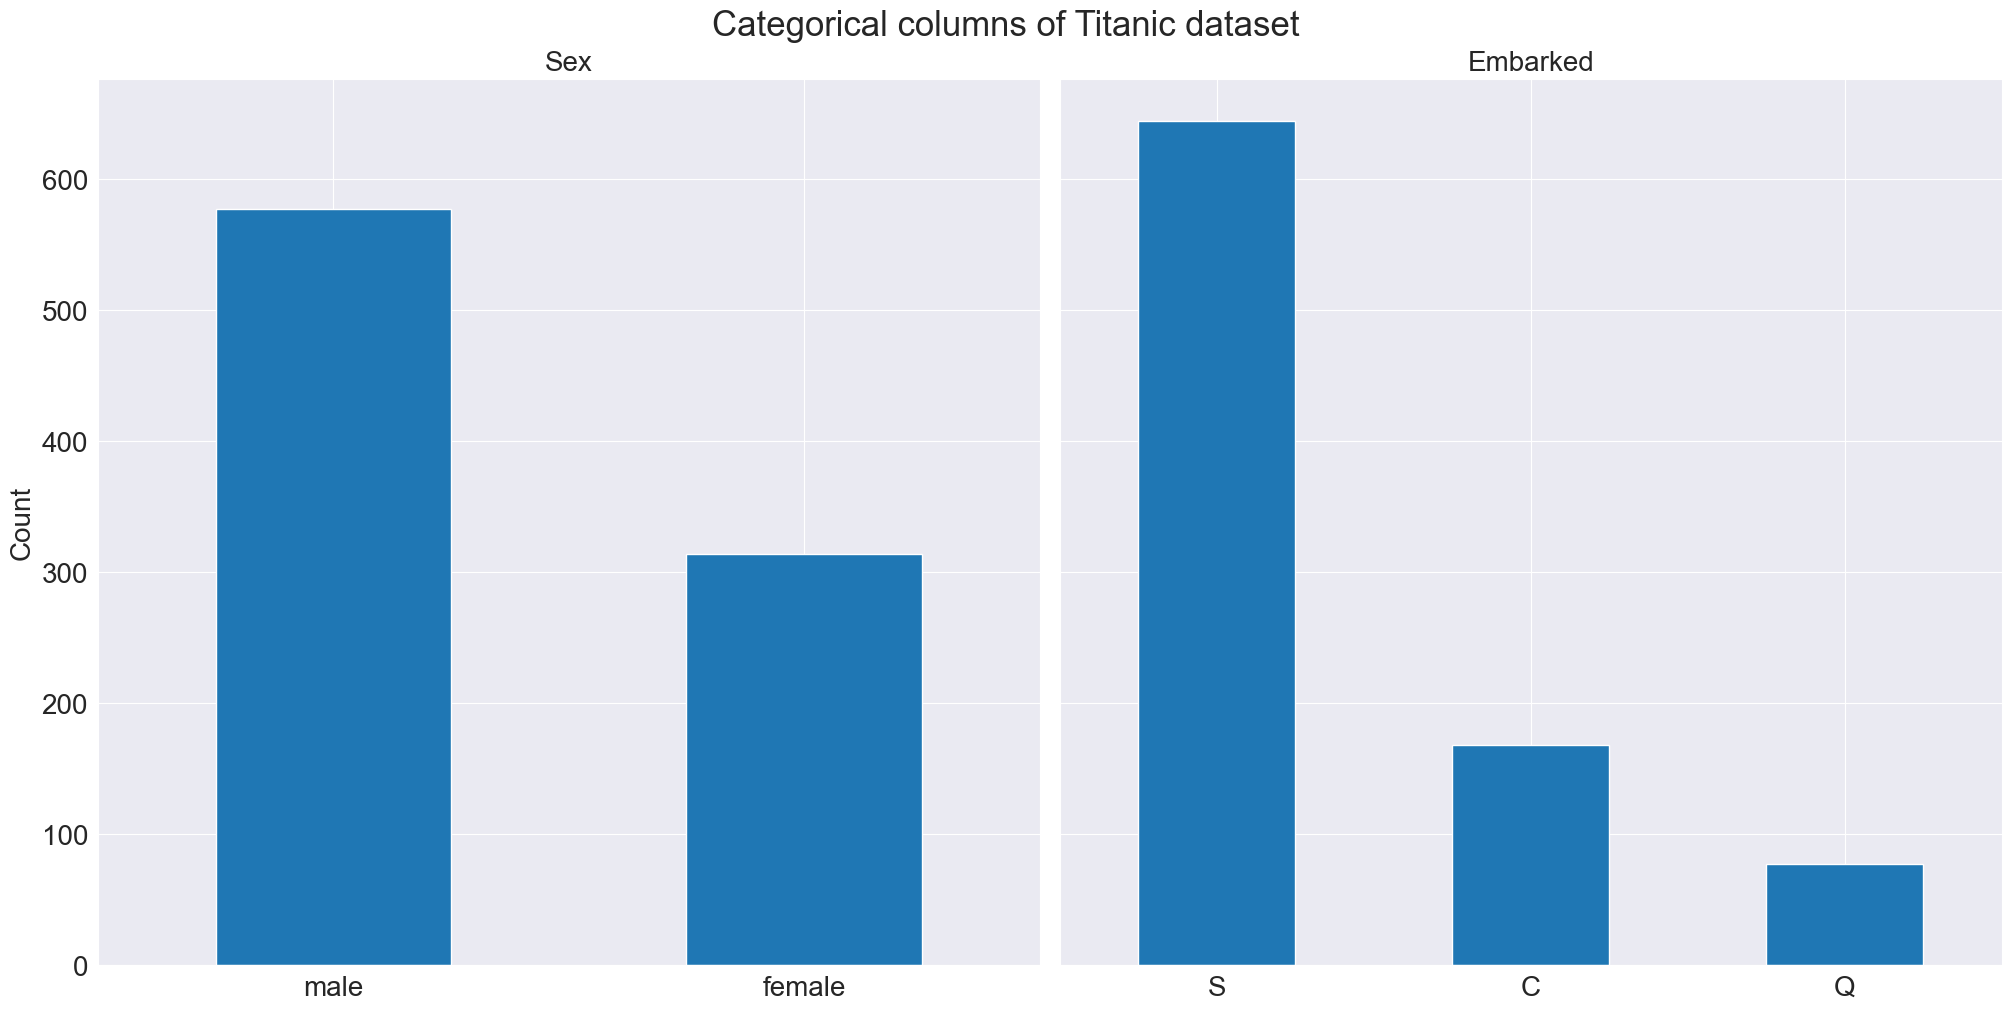

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), layout="constrained", sharey='all')
fig.suptitle("Categorical columns of Titanic dataset", fontsize=25)
for i, col in enumerate(list(categorical_columns)):
    titanic_df[col].value_counts().plot(kind='bar', ax = ax[i])
    ax[i].set_title(col)
    ax[i].set_ylabel("Count")
    ax[i].set_xlabel("")
    ax[i].tick_params(labelrotation=0)
plt.show()

As we can see, males dominate the *Gender* class, and S dominates the *Embarked* class.

Let us now check the numerical columns distribution:

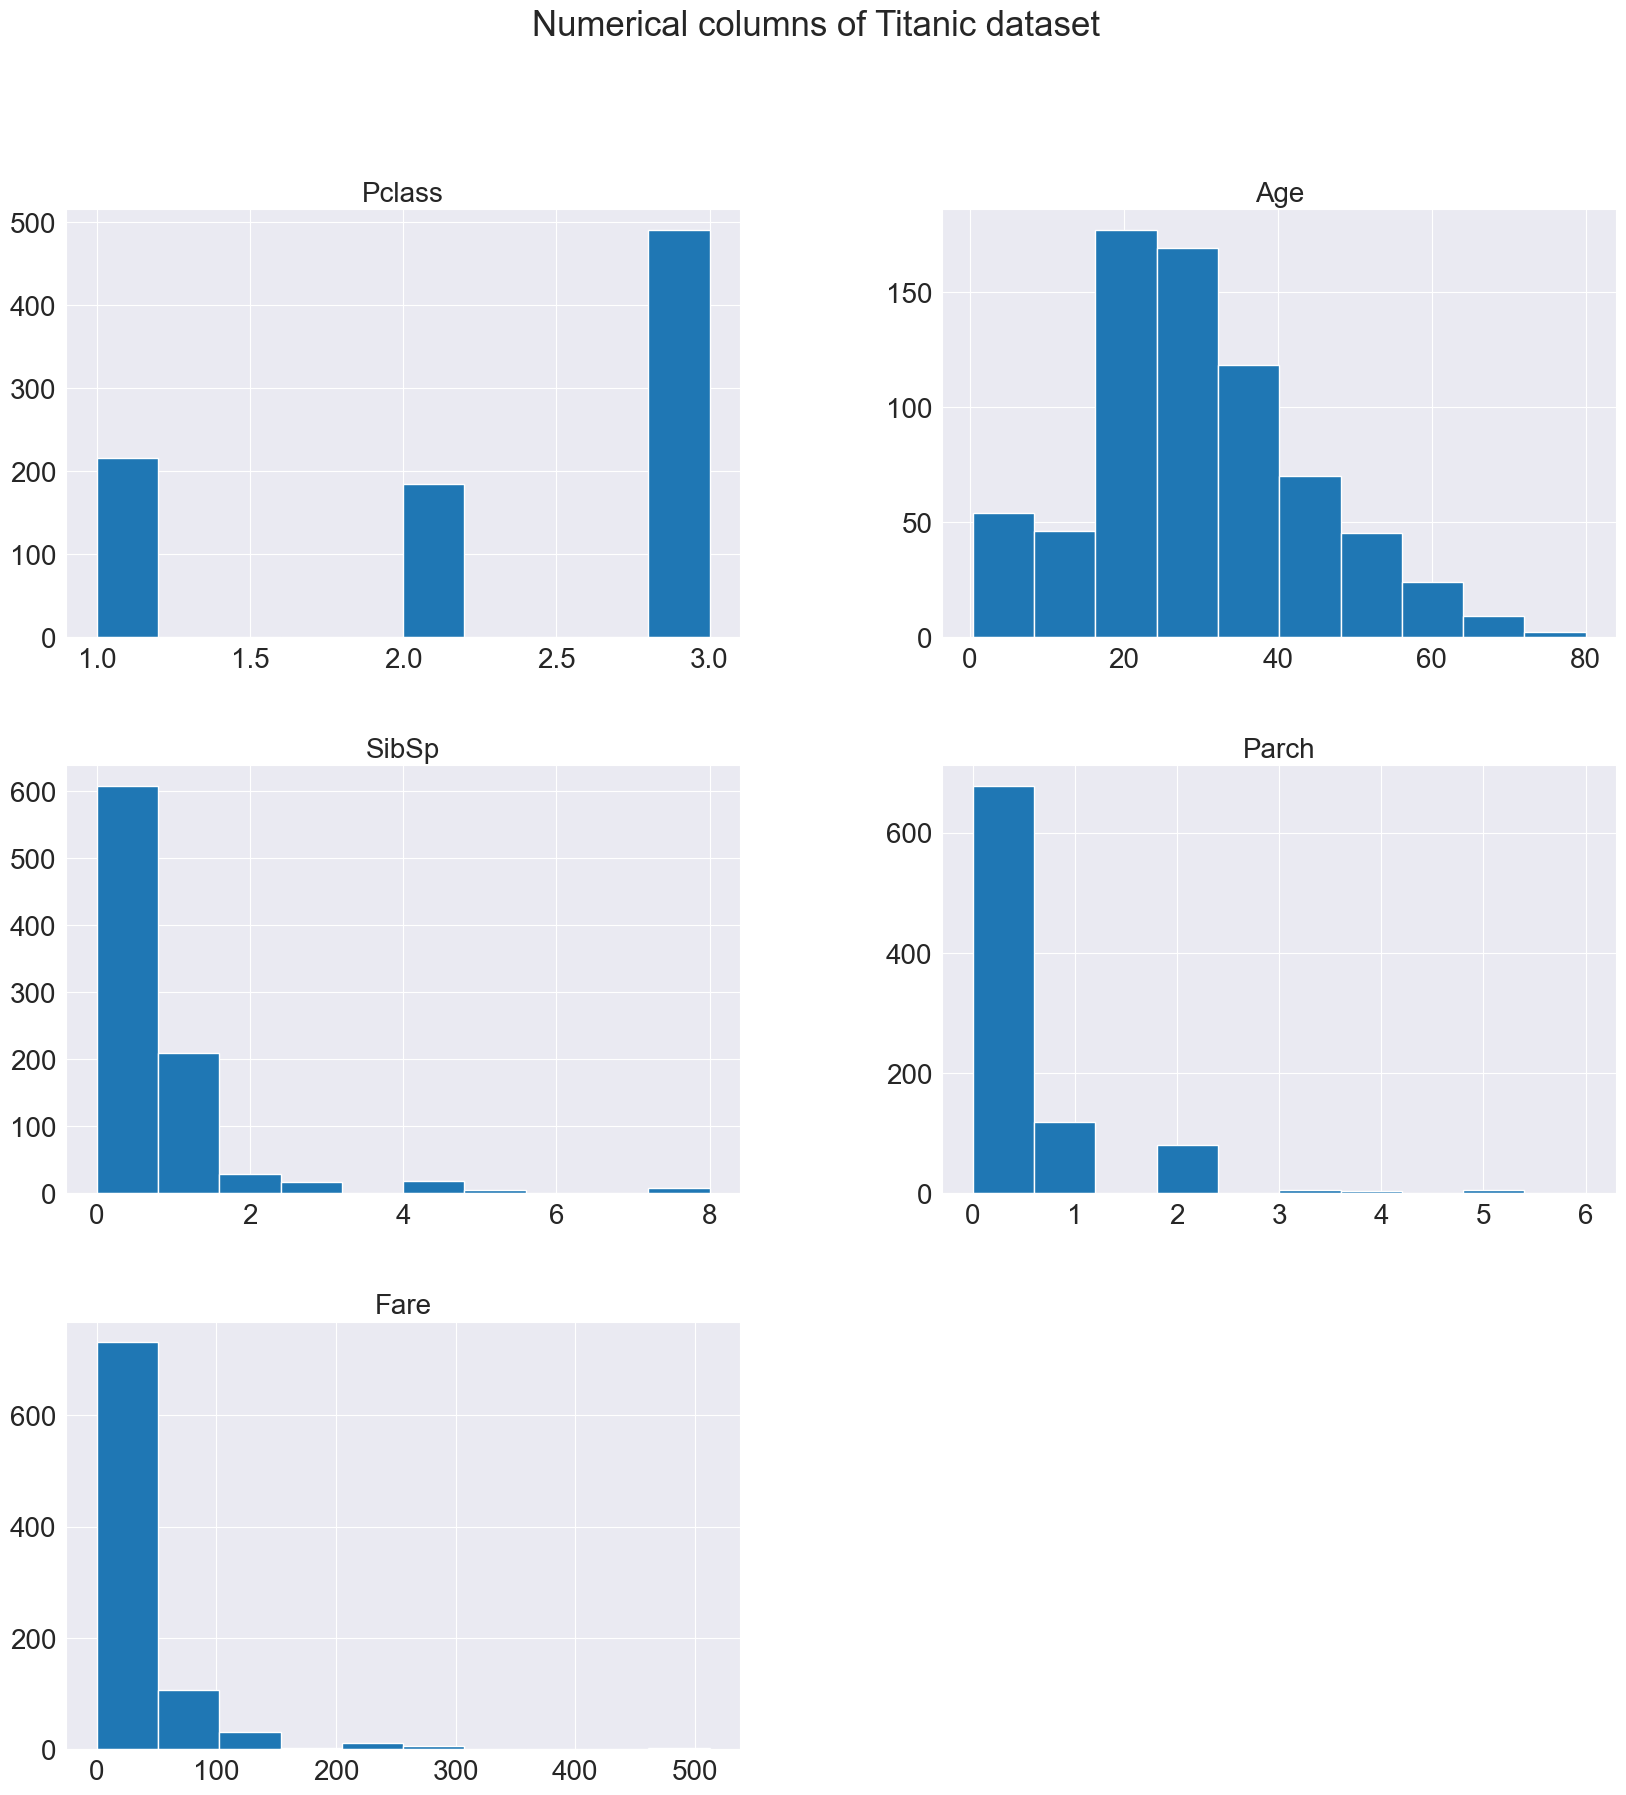

In [20]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
fig.delaxes(ax[2,1])
fig.suptitle("Numerical columns of Titanic dataset", fontsize=25)
titanic_df[numerical_columns].hist(ax=ax.flatten()[:5])
plt.show()


As we can see, most of the values here are skewed.
What is more, *Pclass* has only 3 distinct values.

Lastly, lets check the distribution for the *survived* variable.

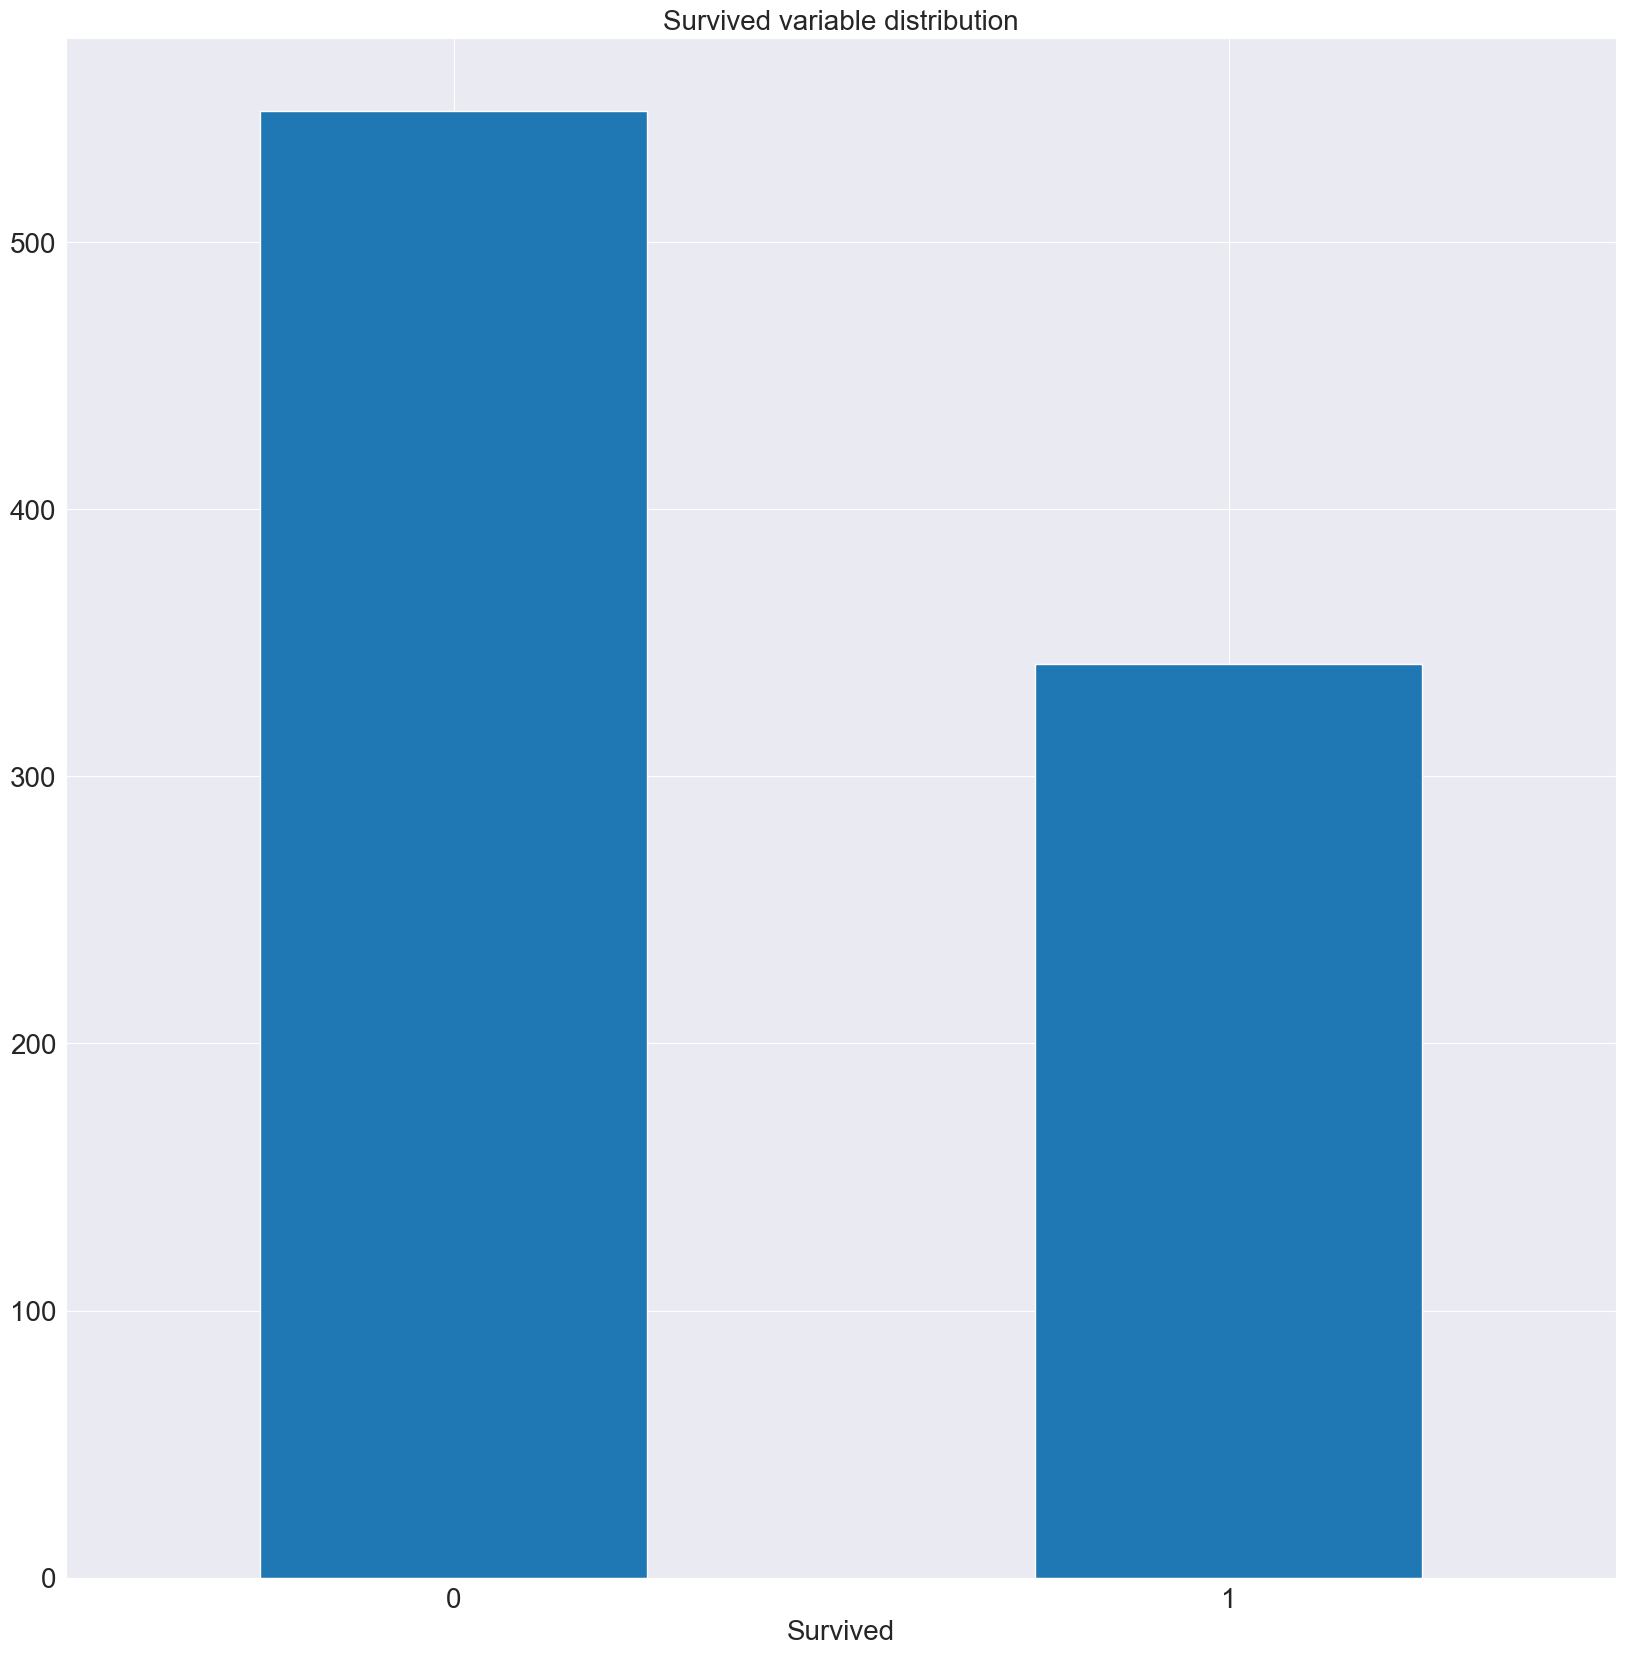

In [21]:
fig, ax = plt.subplots(figsize=(20,20))
titanic_df['Survived'].value_counts().plot(kind='bar', ax = ax)
plt.title("Survived variable distribution")
plt.xticks(rotation=0)
plt.show()

As we can see, the classes are sligtly unbalanced.

Let us also check the distributions of values from the **Banknote dataset**:

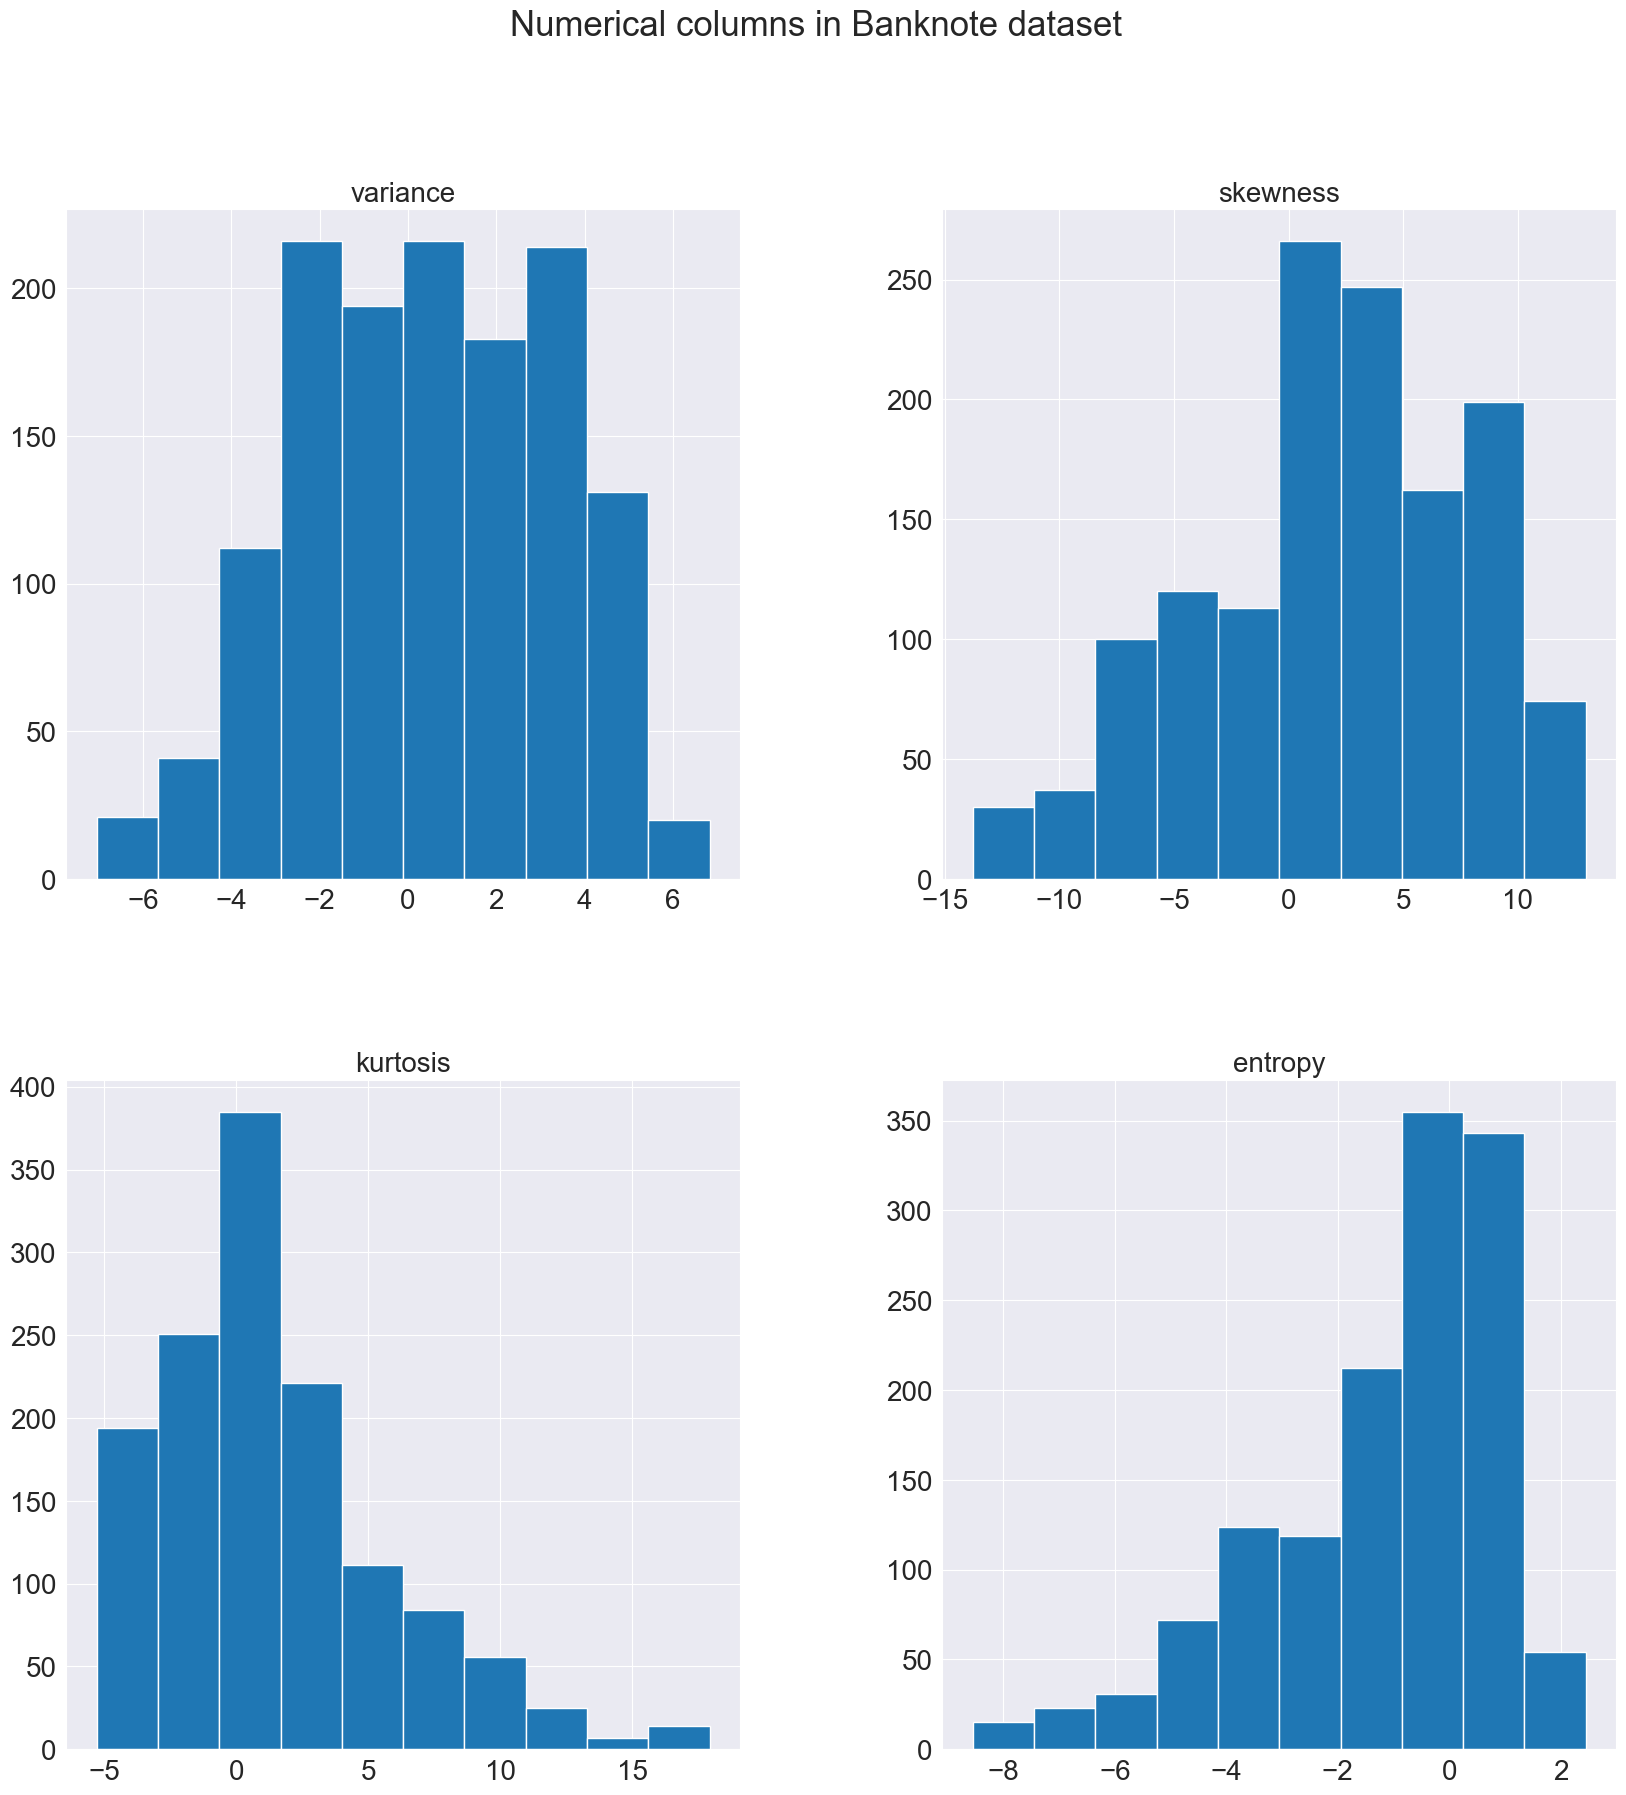

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle("Numerical columns in Banknote dataset", fontsize=25)
bank_df[bank_variables].hist(ax=ax)
plt.show()

Here, values are slightly "better" distributed.
Lastly, let us look at the class variable in the **Banknote dataset**:

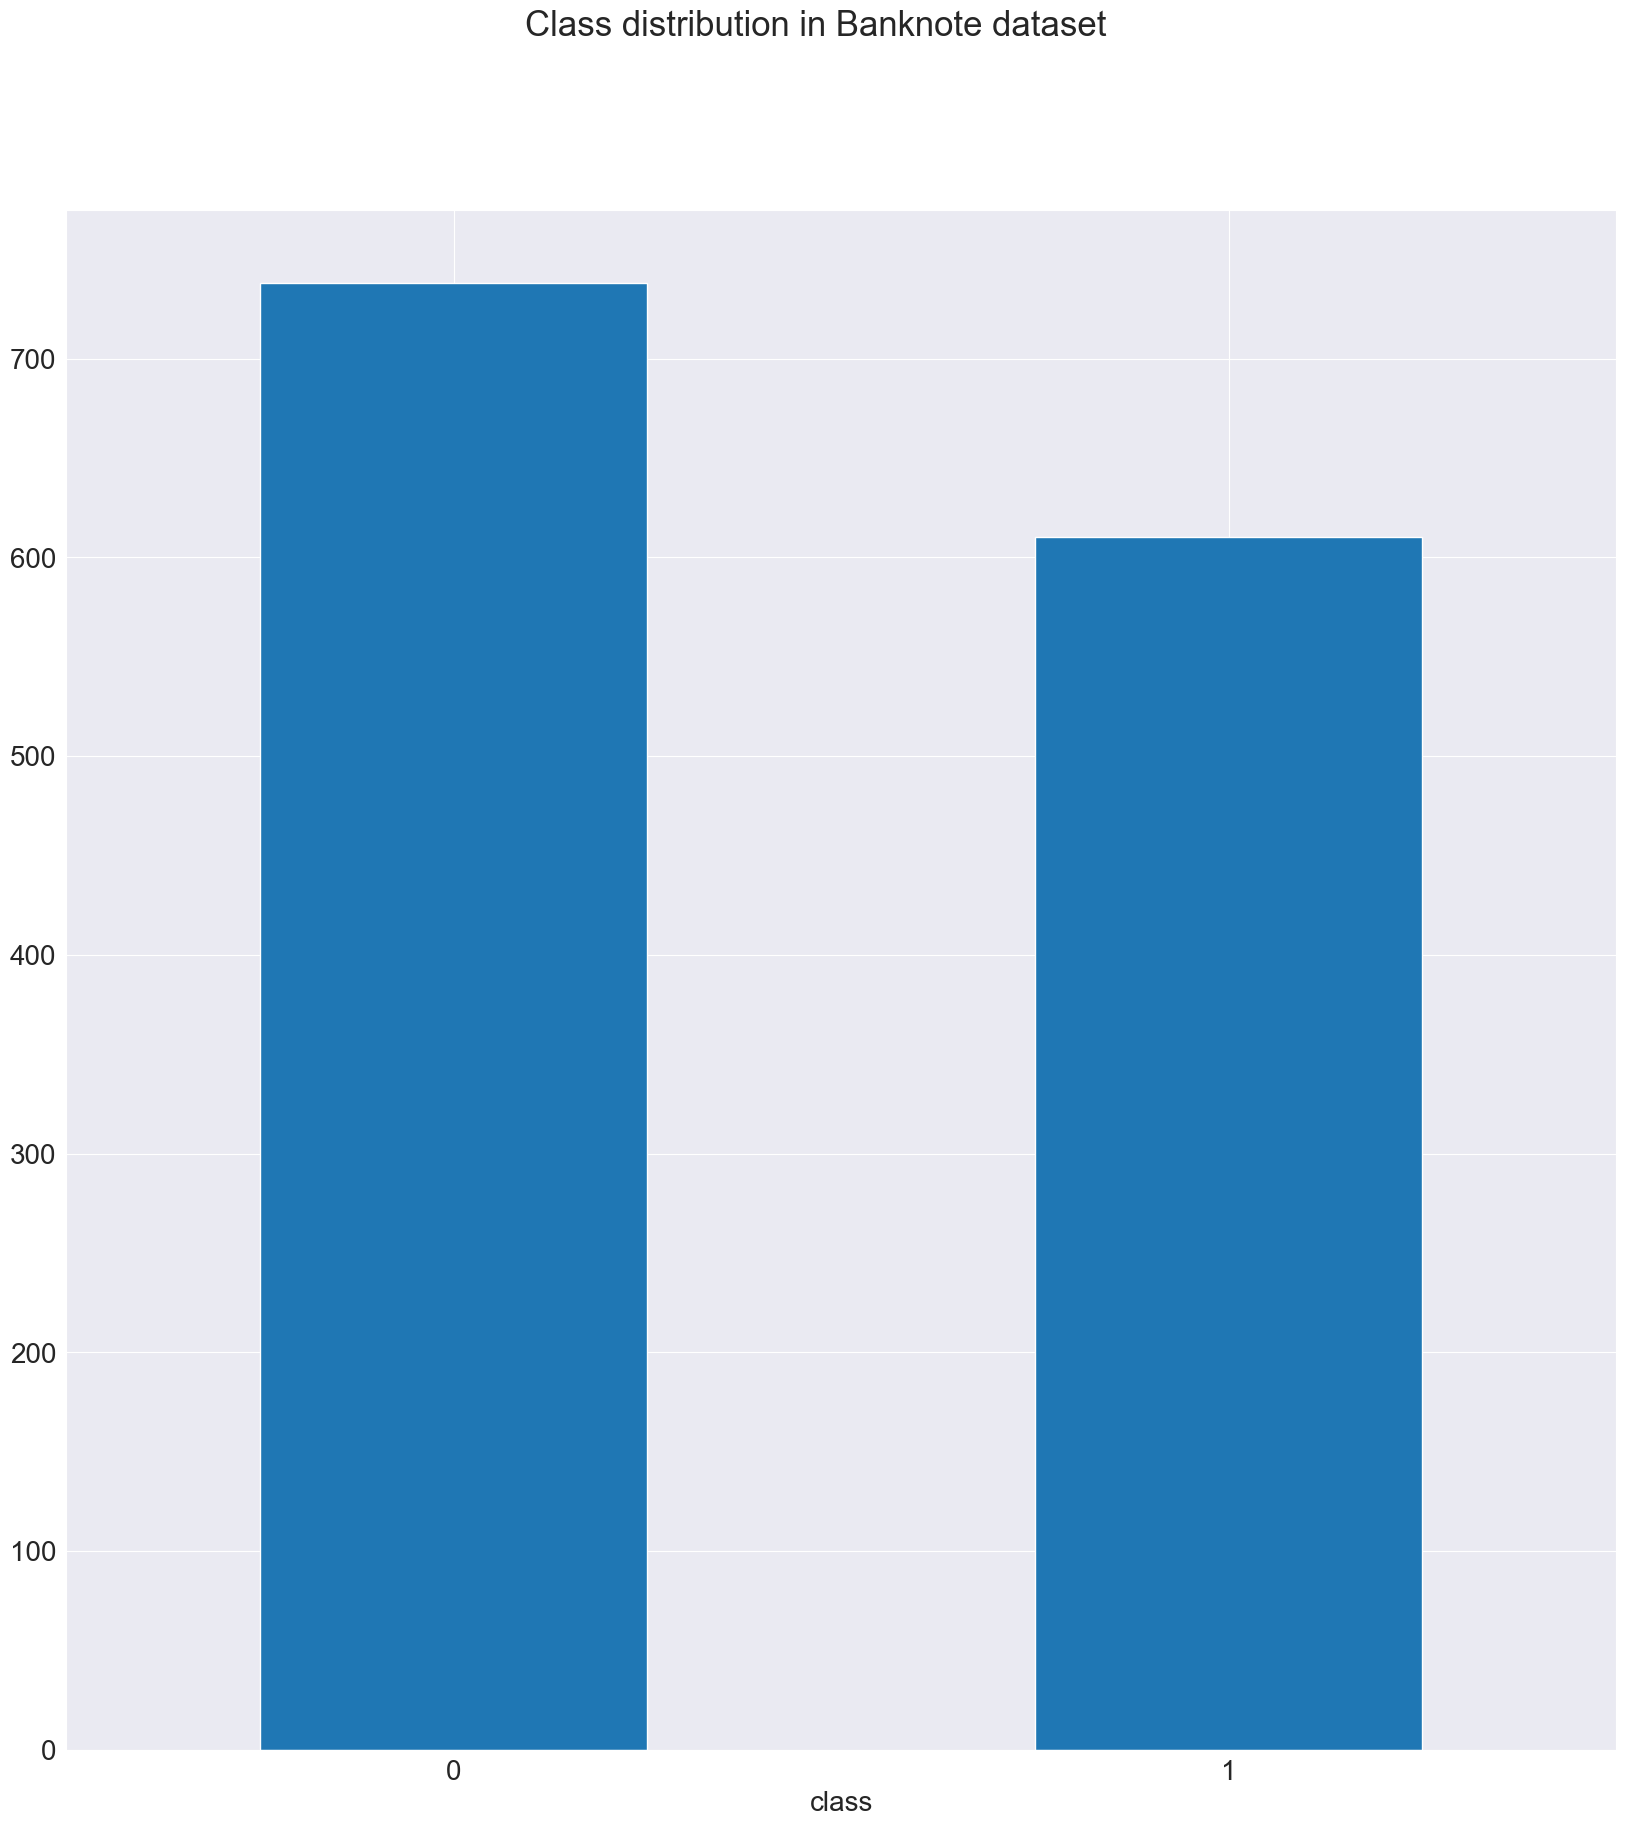

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
fig.suptitle("Class distribution in Banknote dataset", fontsize=25)
bank_df.iloc[:, -1].value_counts().plot(kind='bar', ax=ax)
plt.xticks(rotation=0)
plt.show()

They are better balanced than in the **Titanic dataset**.

# Encoding categorical variables

After investigating numerical values, we have decided that it will be benefitial to scale the numerical variables in our datasets.

In [38]:
numerical_columns = [1, 2, 3, 4]

In [39]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
ct_titanic = Pipeline([
    ('imputer', ColumnTransformer(transformers=[('imputer', SimpleImputer(missing_values=np.nan, strategy='median'), [1])],
                                  remainder='passthrough')),
    ('scaler', ColumnTransformer(transformers=[('scaler', StandardScaler(), numerical_columns)],
                                 remainder='passthrough'))
                       ])
ct_titanic_scaler = ColumnTransformer([('scaler', StandardScaler(), numerical_columns)])
ct_bank = ColumnTransformer([('scaler', StandardScaler(), bank_variables)])

The **banknote dataset** does not have any categorical variables, so we will focus on the **Stroke dataset**.
For categorical variables, we will use one-hot encoding.

In [26]:
titanic_df = pd.get_dummies(titanic_df, drop_first=True)

In [27]:
for column in titanic_df.columns:
    if titanic_df[column].dtype == 'bool':
        titanic_df[column] = titanic_df[column].astype(np.int32)

Let us now also split datets into predictors and responses.

In [28]:
X_t, y_t = titanic_df.drop('Survived', axis=1), titanic_df['Survived']
X_bank, y_bank = bank_df.drop('class', axis=1), bank_df['class']

# Splitting data into train and test

Let us split both datasets: 80% for training and 20% for testing.

In [29]:
from sklearn.model_selection import train_test_split
titanic_df_X_train, titanic_df_X_test, titanic_df_y_train, titanic_df_y_test = train_test_split(X_t, y_t,
                                                                                            test_size=0.2, random_state=12)
bank_df_X_train, bank_df_X_test, bank_df_y_train, bank_df_y_test = train_test_split(X_bank, y_bank,
                                                                                    test_size=0.2,
                                                                                    random_state=12)

# Collinearity

Let us check the collinearity between the values of **Titanic dataset**.

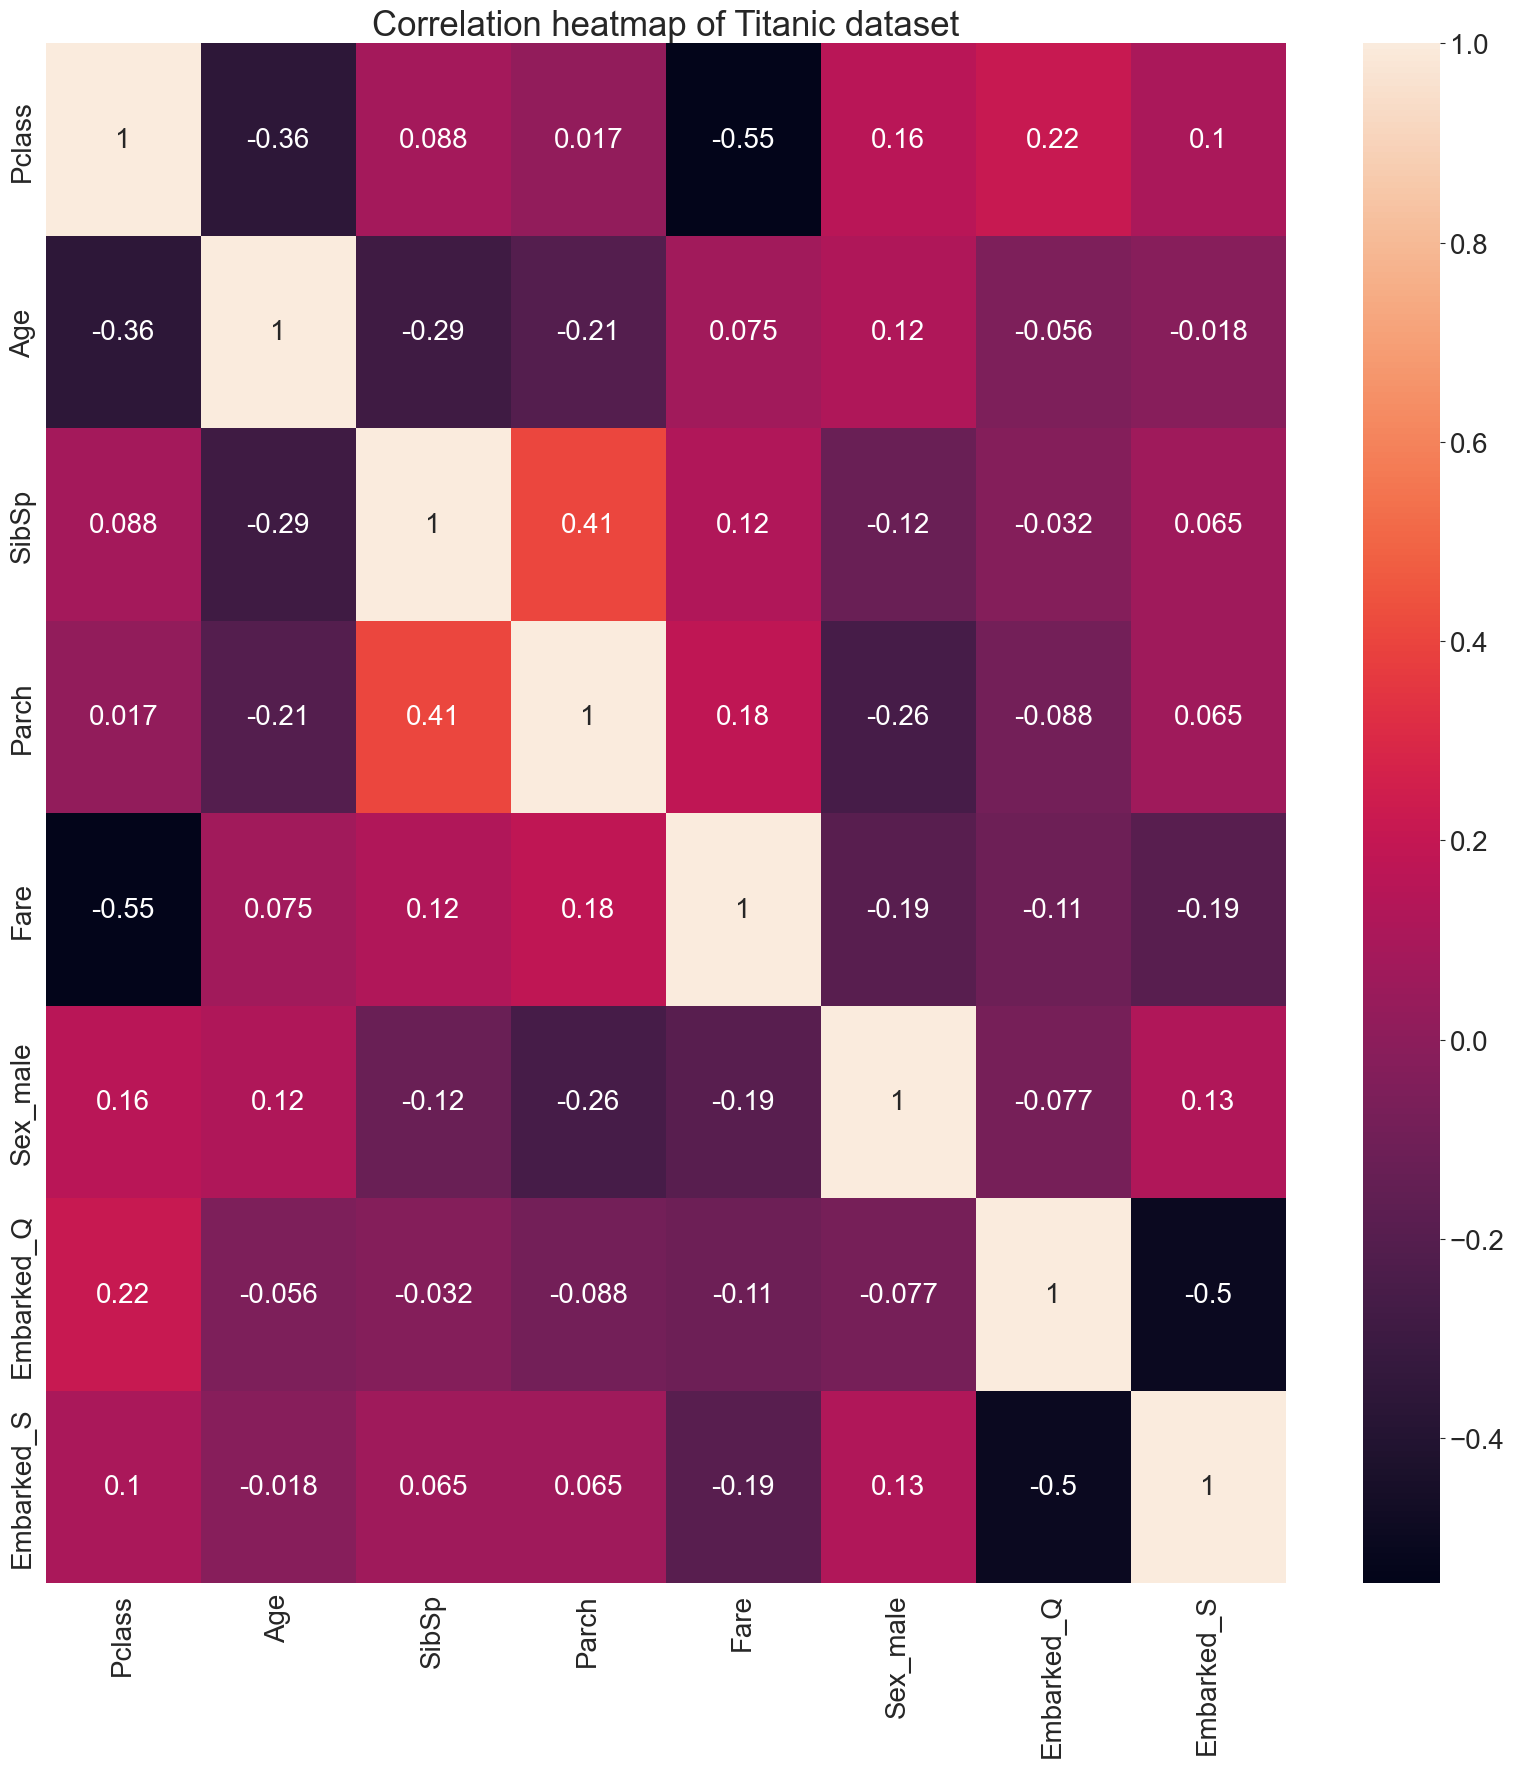

In [30]:
plt.figure(figsize=(20,20))
sns.heatmap(titanic_df_X_train.corr(), annot=True)
plt.title("Correlation heatmap of Titanic dataset", fontsize=25)
plt.show()

There seems to be small correlation between *Fare* and *Pclass*, but it's not very significant.

Let us also investigate the collinearity in the **Banknote dataset**:

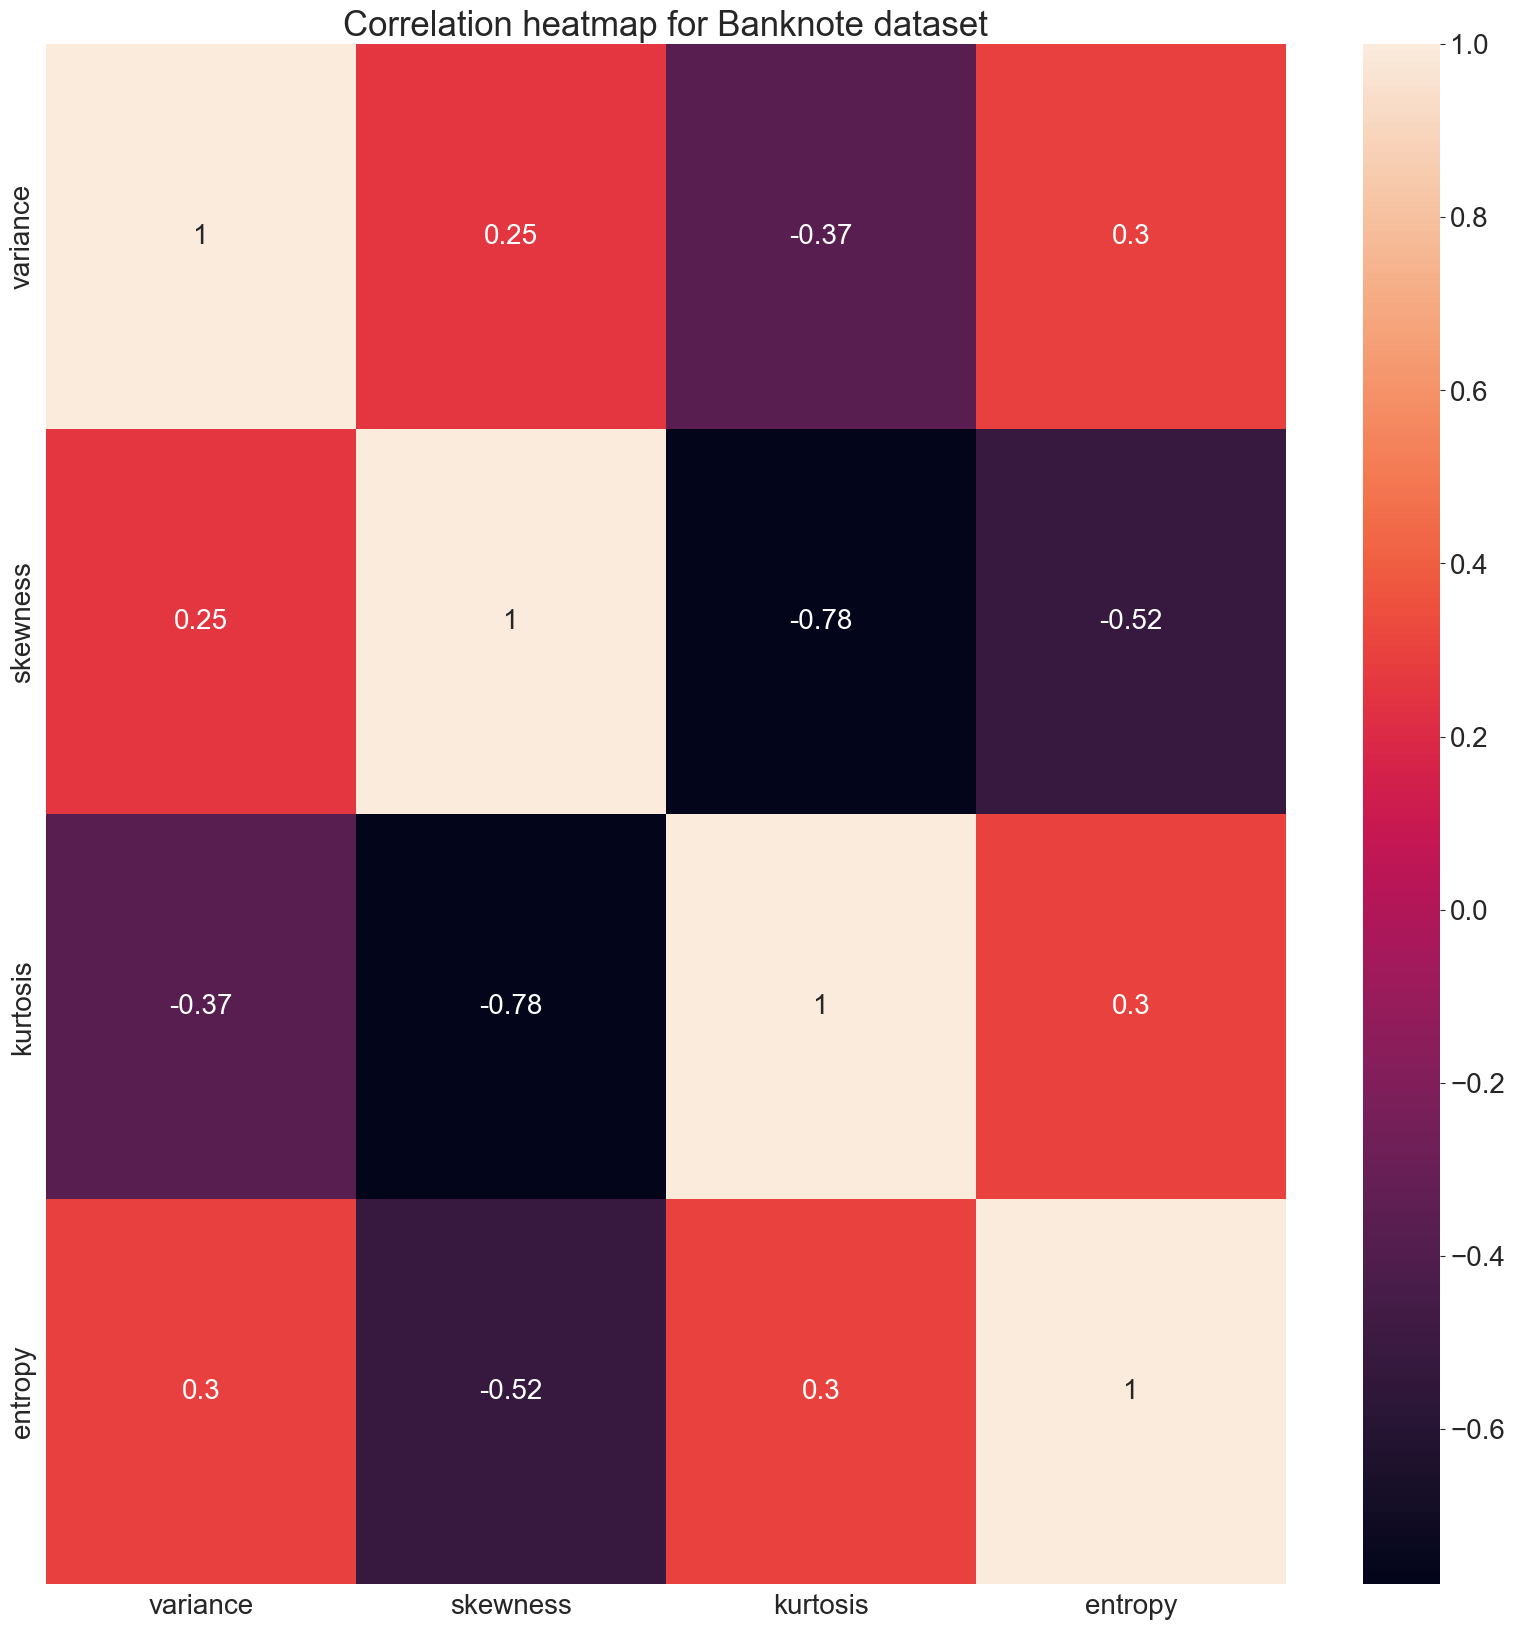

In [31]:
plt.figure(figsize=(20,20))
sns.heatmap(bank_df_X_train.corr(), annot=True)
plt.title("Correlation heatmap for Banknote dataset", fontsize=25)
plt.show()

Kurtosis and skewness seem to be somewhat correlated, but again, it is not significant.

# Loading models

In [32]:
# Implemented model
from IRLS import IRLS
# SKlearn models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR

We will consider multiple metrics: accuracy, balanced accuracy, f1-score, precision and recall scores.

In [33]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
def compute_metrics(y, y_hat, verbose=False, pos_label=1):
    """
    :param y: true values
    :param y_hat: predicted values
    :param verbose: boolean, decides whether or not algorithm should print all the results
    :param pos_label: the positive label (for f1, precision and recall), default: 1
    :return: metrics: accuracy, balanced accuracy, f1 score, precision, recall
    """
    acc = accuracy_score(y, y_hat)
    b_acc = balanced_accuracy_score(y, y_hat)
    f1 = f1_score(y, y_hat, pos_label=pos_label)
    prec = precision_score(y, y_hat, pos_label=pos_label)
    recall = recall_score(y, y_hat, pos_label=pos_label)
    if verbose:
        print(f"Accuracy score: {acc}")
        print(f"Balanced accuracy score: {b_acc}")
        print(f"F1 score: {f1}")
        print(f"Precision score: {prec}")
        print(f"Recall score: {recall}")
    return acc, b_acc, f1, prec, recall



In [64]:
lr = IRLS()
pipe = Pipeline([('preprocess', ct_titanic), ('LDA', lr)])

In [65]:
pipe.fit(titanic_df_X_train, titanic_df_y_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imputer',
                                                                   SimpleImputer(strategy='median'),
                                                                   [1])])),
                                 ('scaler',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('scaler',
                                                                   StandardScaler(),
                                                                   [1, 2, 3,
                                                                    4])]))])),
                ('LDA', <IRLS.IRLS object at 0x0000023D84472F50>)])

In [66]:
y = pipe.predict(titanic_df_X_test)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 712 and the array at index 1 has size 179

In [63]:
compute_metrics(titanic_df_y_test, y, verbose=True)

Accuracy score: 0.6983240223463687
Balanced accuracy score: 0.6848101265822786
F1 score: 0.625
Precision score: 0.6923076923076923
Recall score: 0.569620253164557


(0.6983240223463687,
 0.6848101265822786,
 0.625,
 0.6923076923076923,
 0.569620253164557)

# Fitting and evaluating models

In [ ]:
# TODO

# Model with and without interactions

In [ ]:
# TODO